In [1]:
import os
import sys


# Import SparkSession
from pyspark.sql import SparkSession

# Build the SparkSession
spark = SparkSession.builder \
    .master("local[10]") \
    .appName("FBT") \
    .config("spark.executor.memory", "6G") \
    .config("spark.storage.memoryFraction", 0.2) \
    .config("spark.driver.memory", "16G") \
    .getOrCreate()
   
sc = spark.sparkContext

In [2]:
sc.getConf().getAll()

[('spark.storage.memoryFraction', '0.2'),
 ('spark.driver.memory', '16G'),
 ('spark.executor.memory', '6G'),
 ('spark.driver.port', '39975'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '172.31.5.36'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1530945810816'),
 ('spark.master', 'local[10]'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'FBT'),
 ('spark.submit.deployMode', 'client')]

In [3]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

schema = StructType([
    StructField("order_id", IntegerType(), True),
    StructField("product_id", IntegerType(), True)])

In [4]:
df = spark.read.load("fbt_without_categories_6_july.csv", header=True, format="csv", schema=schema).cache();
df.count()

37498790

In [5]:
df.show(10)

+--------+----------+
|order_id|product_id|
+--------+----------+
|  386449|       885|
|  386449|     16985|
|  386449|     19632|
|  386449|     19637|
|  386450|      3062|
|  386450|      8666|
|  386450|     18659|
|  386451|       809|
|  386451|     18584|
|  386452|      7633|
+--------+----------+
only showing top 10 rows



In [6]:
df = df.groupBy(['order_id', 'product_id']).agg({'product_id': 'count'}).drop('count(product_id)')

In [7]:
product_2_orders_cnt_df = df.groupBy(['product_id']).agg({'order_id': 'count'}).withColumnRenamed('count(order_id)', 'orders_cnt').toPandas()
product_2_orders_cnt = dict(zip(product_2_orders_cnt_df.product_id, product_2_orders_cnt_df.orders_cnt))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [8]:
unique_products = [row['product_id'] for row in df.select('product_id').distinct().collect()]
len(unique_products)

65285

In [9]:
merged_df = df.withColumnRenamed('product_id', 'product_id_x').join(df.withColumnRenamed('product_id', 'product_id_y'), on='order_id', how='inner')
merged_df.count()

204466446

In [ ]:
merged_df.show(10)

In [10]:
merged_df = merged_df.filter('product_id_x < product_id_y')
merged_df.count()

83483828

In [11]:
merged_df = merged_df.groupBy(['product_id_x', 'product_id_y']).agg({'order_id': 'count'}).withColumnRenamed('count(order_id)', 'orders_intersection')
merged_df.count()

14120673

In [ ]:
merged_df.show(10)

In [12]:
final_df = merged_df

# Using Histogram for visualizing products that are removed from FBT table when using different threshold

In [13]:
import matplotlib.pyplot as plt

data = {}
for i in range(1, 10, 1):
    _df = final_df[final_df['orders_intersection'] >= i]
    _unique_products_x = [row['product_id_x'] for row in _df.select('product_id_x').distinct().collect()]
    _unique_products_y = [row['product_id_y'] for row in _df.select('product_id_y').distinct().collect()]
    _unique_products = set(_unique_products_x + _unique_products_y)
    data[i] = len(_unique_products)

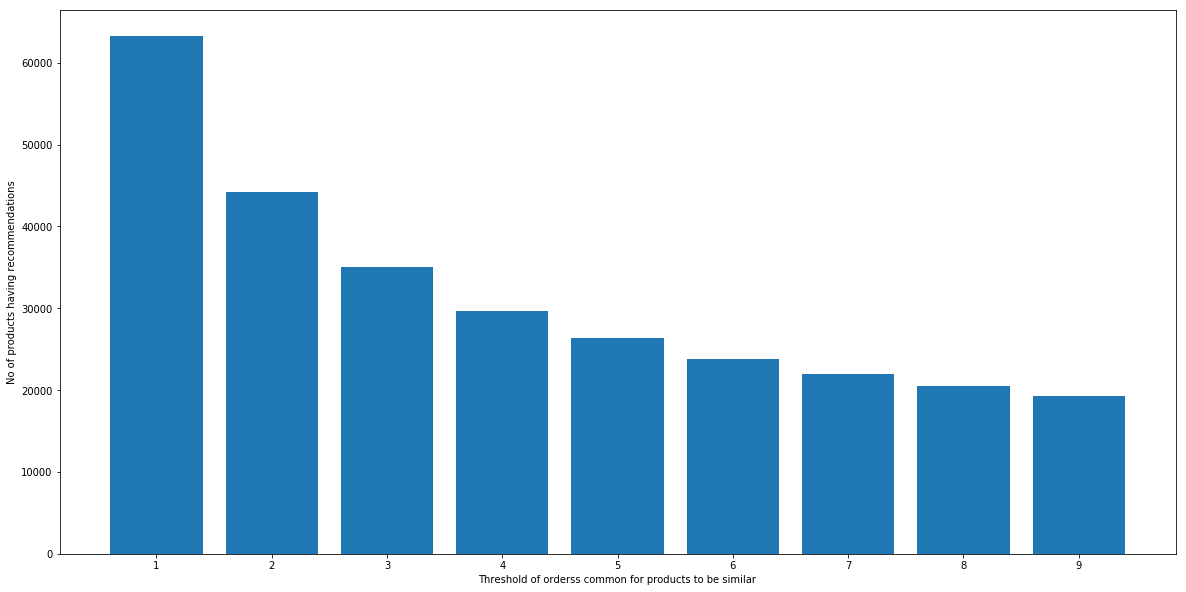

In [14]:
plt.figure(figsize=(20,10))
plt.xlabel('Threshold of orderss common for products to be similar')
plt.ylabel('No of products having recommendations')
plt.bar(range(len(data)), data.values(), align='center')
plt.xticks(range(len(data)), list(data.keys()))

plt.show()

Using orders threshold of 2 for products to be similar

In [15]:
final_df = final_df[final_df['orders_intersection'] >= 2]

In [16]:
final_df.count()

6144634

# Computing orders Union and different similarities

In [17]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def compute_orders_union_len(product_id_x, product_id_y, orders_intersection):
     return product_2_orders_cnt[product_id_x] + product_2_orders_cnt[product_id_y] - orders_intersection

compute_orders_union_len_udf = udf(compute_orders_union_len, IntegerType())
final_df = final_df.withColumn("orders_union", compute_orders_union_len_udf(final_df['product_id_x'], final_df['product_id_y'], final_df['orders_intersection']))

In [18]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

def compute_direct_similarity(orders_intersection, orders_union):
     return orders_intersection/orders_union

compute_direct_similarity_udf = udf(compute_direct_similarity, FloatType())
final_df = final_df.withColumn("direct_similarity", compute_direct_similarity_udf(final_df['orders_intersection'], final_df['orders_union']))

In [19]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import math

def compute_log_similarity(orders_intersection, parent_id, similar_product_id):
     return orders_intersection/product_2_orders_cnt[parent_id]/math.log(product_2_orders_cnt[similar_product_id])

compute_log_similarity_udf = udf(compute_log_similarity, FloatType())
final_df = final_df.withColumn("log_similarity_y_x", compute_log_similarity_udf(final_df['orders_intersection'], final_df['product_id_x'], final_df['product_id_y']))
final_df = final_df.withColumn("log_similarity_x_y", compute_log_similarity_udf(final_df['orders_intersection'], final_df['product_id_y'], final_df['product_id_x']))

In [20]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import math

def compute_sqrt_similarity(orders_intersection, parent_id, similar_product_id):
     return orders_intersection/product_2_orders_cnt[parent_id]/math.sqrt(product_2_orders_cnt[similar_product_id])

compute_sqrt_similarity_udf = udf(compute_sqrt_similarity, FloatType())
final_df = final_df.withColumn("sqrt_similarity_y_x", compute_sqrt_similarity_udf(final_df['orders_intersection'], final_df['product_id_x'], final_df['product_id_y']))
final_df = final_df.withColumn("sqrt_similarity_x_y", compute_sqrt_similarity_udf(final_df['orders_intersection'], final_df['product_id_y'], final_df['product_id_x']))

# Get Recommendations function

In [ ]:
from pyspark.sql import SQLContext

import sys
sys.path.append("/nykaa/api")
from pas.v2.utils import Utils

sqlContext = SQLContext(sc)
final_df.createOrReplaceTempView("final_df")

def get_recommendations(product_id, recommendations_cnt=10, with_name=True, algo='coccurence_direct'):
    if variant == 'coccurence_log':
        order_by = 'log_similarity'
    elif variant == 'coccurence_sqrt':
        order_by = 'sqrt_similarity'
    elif variant == 'coccurence_direct':
        order_by = 'direct_similarity'
    else:
        order_by = 'orders_intersection'
        
    rows = sqlContext.sql("SELECT * FROM final_df WHERE product_id_x=%d OR product_id_y=%d ORDER BY %s DESC LIMIT %d" % (product_id, product_id, order_by, recommendations_cnt)).collect()
    recommendation_ids = []
    for row in rows:
        if row['product_id_x'] == product_id:
            recommendation_ids.append(row['product_id_y'])
        else:
            recommendation_ids.append(row['product_id_x'])
    if not with_name:
        return recommendation_ids
    query = {
        "query": {
            "terms": {"product_id.keyword": recommendation_ids}
        },
        "_source": ['title_text_split', 'product_id']
    }
    
    response = Utils.makeESRequest(query, index='livecore')
    product_id_2_name = {int(hit['_source']['product_id']): hit['_source']['title_text_split'] for hit in response['hits']['hits']}
    return [(recommendation_id, product_id_2_name.get(recommendation_id)) for recommendation_id in recommendation_ids]

# Preparing dictionary of similar products

In [24]:
from collections import defaultdict

simple_similar_products_dict = defaultdict(lambda: [])
direct_similar_products_dict = defaultdict(lambda: [])
log_similar_products_dict = defaultdict(lambda: [])
sqrt_similar_products_dict = defaultdict(lambda: [])

for row in final_df.collect():
    simple_similar_products_dict[row['product_id_x']].append((row['product_id_y'], row['orders_intersection']))
    simple_similar_products_dict[row['product_id_y']].append((row['product_id_x'], row['orders_intersection']))
    
    direct_similar_products_dict[row['product_id_x']].append((row['product_id_y'], row['direct_similarity']))
    direct_similar_products_dict[row['product_id_y']].append((row['product_id_x'], row['direct_similarity']))
    
    log_similar_products_dict[row['product_id_x']].append((row['product_id_y'], row['log_similarity_y_x']))
    log_similar_products_dict[row['product_id_y']].append((row['product_id_x'], row['log_similarity_x_y']))
    
    sqrt_similar_products_dict[row['product_id_x']].append((row['product_id_y'], row['sqrt_similarity_y_x']))
    sqrt_similar_products_dict[row['product_id_y']].append((row['product_id_x'], row['sqrt_similarity_x_y']))

# Adding Data to MYSQL

In [25]:
%%time
import sys
sys.path.append('/nykaa/api')
from pas.v2.utils import Utils

pasdb = Utils.mysqlConnection('w')
cursor = pasdb.cursor()

create_recommendations_table_query = """ CREATE TABLE IF NOT EXISTS recommendations_v2 (
                            entity_id INT UNSIGNED NOT NULL, 
                            entity_type VARCHAR(50),
                            recommendation_type VARCHAR(50),
                            algo VARCHAR(50),
                            recommended_products_json JSON,
                            PRIMARY KEY (entity_id, entity_type, recommendation_type, algo)
                            )
"""
cursor.execute(create_recommendations_table_query)

def add_recommendations_in_mysql(db, cursor, rows):
    values_str = ", ".join(["(%s, %s, %s, %s, %s)" for i in range(len(rows))])
    values = tuple([_i for row in rows for _i in row])
    insert_recommendations_query = """ INSERT INTO recommendations_v2(entity_id, entity_type, recommendation_type, algo, recommended_products_json)
            VALUES %s ON DUPLICATE KEY UPDATE recommended_products_json=VALUES(recommended_products_json)
    """ % values_str
    values = tuple([str(_i) for row in rows for _i in row])
    cursor.execute(insert_recommendations_query, values)
    db.commit()
    
rows = []
products_count = 0
for product_id in unique_products:
    if not simple_similar_products_dict[product_id]:
        continue

    simple_similar_products = list(map(lambda e: e[0], sorted(simple_similar_products_dict[product_id], key=lambda e: e[1], reverse=True)[:20]))
    direct_similar_products = list(map(lambda e: e[0], sorted(direct_similar_products_dict[product_id], key=lambda e: e[1], reverse=True)[:20]))
    log_similar_products = list(map(lambda e: e[0], sorted(log_similar_products_dict[product_id], key=lambda e: e[1], reverse=True)[:20]))
    sqrt_similar_products = list(map(lambda e: e[0], sorted(sqrt_similar_products_dict[product_id], key=lambda e: e[1], reverse=True)[:20]))

    rows.append((product_id, 'product', 'fbt', 'coccurence_simple', str(simple_similar_products)))
    rows.append((product_id, 'product', 'fbt', 'coccurence_direct', str(direct_similar_products)))
    rows.append((product_id, 'product', 'fbt', 'coccurence_log', str(log_similar_products)))
    rows.append((product_id, 'product', 'fbt', 'coccurence_sqrt', str(sqrt_similar_products)))
    products_count += 1
    if len(rows) == 40:
        add_recommendations_in_mysql(pasdb, cursor, rows)
        rows = []
        
add_recommendations_in_mysql(pasdb, cursor, rows)

cursor.close()
pasdb.close()
print(products_count)

44205
CPU times: user 31.7 s, sys: 148 ms, total: 31.9 s
Wall time: 48.5 s


# Writing data for simple variants from configurable products using mysql

In [26]:
%%time
import json

nykaadb = Utils.nykaaMysqlConnection()
nykaa_cursor = nykaadb.cursor()
query = "select parent_id, child_id from catalog_product_relation"
nykaa_cursor.execute(query) 

parent_2_children = defaultdict(lambda: [])
for row in nykaa_cursor.fetchall():
    parent_2_children[row[0]].append(row[1])
        
with open("child_product_2_parent.json", "r+") as f:
    for key, value in json.load(f).items():
        parent_2_children[int(value)].append(int(key))

pasdb = Utils.mysqlConnection('w')
cursor = pasdb.cursor()
products_count = 0
for parent, variants in parent_2_children.items():
    if not simple_similar_products_dict[parent]:
        continue
    simple_similar_products = list(map(lambda e: e[0], sorted(simple_similar_products_dict[parent], key=lambda e: e[1], reverse=True)[:50]))
    direct_similar_products = list(map(lambda e: e[0], sorted(direct_similar_products_dict[parent], key=lambda e: e[1], reverse=True)[:50]))
    log_similar_products = list(map(lambda e: e[0], sorted(log_similar_products_dict[parent], key=lambda e: e[1], reverse=True)[:50]))
    sqrt_similar_products = list(map(lambda e: e[0], sorted(sqrt_similar_products_dict[parent], key=lambda e: e[1], reverse=True)[:50]))

    rows = []
    for variant in variants:
        rows.append((variant, 'product', 'fbt', 'coccurence_simple', str(simple_similar_products)))
        rows.append((variant, 'product', 'fbt', 'coccurence_direct', str(direct_similar_products)))
        rows.append((variant, 'product', 'fbt', 'coccurence_log', str(log_similar_products)))
        rows.append((variant, 'product', 'fbt', 'coccurence_sqrt', str(sqrt_similar_products)))
        products_count += 1
    
    add_recommendations_in_mysql(pasdb, cursor, rows)

nykaa_cursor.close()
nykaadb.close()

cursor.close()
pasdb.close() 
print(products_count)

146156
CPU times: user 55.3 s, sys: 1.02 s, total: 56.3 s
Wall time: 2min 28s


# Writing data for variants of configurable products using ES

In [ ]:
import json
pasdb = Utils.mysqlConnection('w')
cursor = pasdb.cursor()

es_query = {
    "query": { 
        "bool": {
            "must": [
                {"term": {"type.keyword": "configurable"}},
                {"exists": {"field": "variants"}}
            ]
        } 
    },
    "_source": ["product_id", "variants"],
    "size": 200
}

es_conn = Utils.esConn()
scroll_id = None
added_for_count = 0
no_of_products_added = 0
while True:
    if not scroll_id:
        response = es_conn.search(index='livecore', body=es_query, scroll='5m')
    else:
        response = es_conn.scroll(scroll_id=scroll_id, scroll='5m')
        
    if not response['hits']['hits']:
        break
        
    print("Processing " + str(len(response['hits']['hits'])) + " configurable products")
    batch_product_ids = [hit['_source']['product_id'] for hit in response['hits']['hits']]
    scroll_id = response['_scroll_id']
    select_query = "SELECT product_id, algo, bought_with_json FROM fbt WHERE product_id IN (" + ", ".join(batch_product_ids) + ")"
    cursor.execute(select_query)
    
    product_to_recommendations = {(str(row[0]) + row[1]): row[2] for row in cursor.fetchall()}
    
    for algo in ['coccurence_simple', 'coccurence_direct', 'coccurence_log', 'coccurence_sqrt']:
        for hit in response['hits']['hits']:
            product_id = hit['_source']['product_id']

            if not product_to_recommendations.get(product_id + algo):
                print("No recommendation for product %s %s" % (product_id, algo))
                continue
            added_for_count += 1
            variants = json.loads(hit['_source']['variants'])
            variant_ids = [ele['id'] for key, values in variants.items() for ele in values]
            no_of_products_added += len(variant_ids)
            values_str = ", ".join(["(%s, %s, %s)" for i in range(len(variant_ids))])
            values = []
            for variant_id in variant_ids:
                values += [variant_id, algo, product_to_recommendations[product_id + algo]]
            insert_recommendations_query = """ INSERT INTO fbt(product_id, algo, bought_with_json)
                VALUES %s ON DUPLICATE KEY UPDATE bought_with_json=VALUES(bought_with_json);
            """ % values_str
            cursor.execute(insert_recommendations_query, values)
            pasdb.commit()

cursor.close()
pasdb.close()  

print("Added for %s" % added_for_count)
print ("No of products added %s" % no_of_products_added)